# Simulating neural data with/without a sequence

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
rng = np.random.default_rng(42)

In [2]:
def poisson_FR(n_neurons: int, FR, duration: float):
    """
    Function made by Tom Has.
    Generates neuronal activity from poisson firing rate for one neurons.
    Input:  - n_neurons:   The number of neurons to simulate.
            - FR:          The firing rate of the poisson process. (array<float>)
            - duration:    The length of recording being simulated in seconds.
    Output: - num_spikes:  The total number of spikes generated.
            - spike_times: Spike timings, sorted.
            - ISI:         Inter-spike intervals between all spikes.
    """
    # Generate number of spikes from poisson distribution
    num_spikes = rng.poisson(FR * duration)
    # Initialize arrays for spike timing and inter-spike interval
    spike_times = np.empty(n_neurons, dtype=object)
    ISI = np.empty(n_neurons, dtype=object)
    for n in range(n_neurons):
        # Draw spike timings from uniform distribution
        spike_times[n] = list(np.sort(rng.uniform(0, duration, num_spikes[n])))
        # Calculate ISI per neuron
        ISI[n] = np.diff(spike_times[n])
    return num_spikes, spike_times, ISI

In [4]:
def random_FR(n_neurons):
    """
    Function originally made by Tom Has, but the distribution is changed to an exponential distribution by Pepijn van den Berg
    Draws an array of random firing rates from a gaussian distribution for a specified amount of neurons.
    input:  - n_neurons: The amount of neurons to draw a firing rate for.
    output: - FRs:       Array of firing rates (one FR for each neuron).
    """
    return rng.exponential(1/(3.68), n_neurons)

In [5]:
def random_sequence_template(n_neurons, t_start, t_end, nr_in_sequence): # Experiment with time of sequence
    """
    Function made by Tom Has.
    Generate a template from which sequences can be generated. A template is defined as a set of neuron / spike time
    pairs which represent the mean of where and when spikes are expected to happen.
    input:  - nr_neurons:     The total number of neurons in the virtual recording.
            - t_start:        The earliest point in time at which a sequence can begin in seconds.
            - t_end:          The latest point in time at which a sequence can end in seconds.
            - nr_in_sequence: The number of neurons participating in the sequence.
    output: - timings:        The times that neurons are expected to fire
    
    """
    # Sample which neurons participate in the sequence
    participating = rng.integers(0, n_neurons, nr_in_sequence)
    # Initialize array for keeping track of timings.
    timings = np.empty(n_neurons, dtype=object)
    # Set each element to an empty array
    for i in range(n_neurons):
        timings[i] = []
    # For every neuron participating, instead generate a random timing
    for n in participating:
        timings[n].append(rng.uniform(t_start, t_end))
    return timings, participating

In [6]:
def template2sequence(timings, jitter, delay=0):
    """
    Function made by Tom Has.
    Generates a sequence from a sequence template. The resulting sequence resembles the template with some variations
    in spike timing.
    Input:  - timings:       The spike timings in the template.
            - jitter:        Standard deviation of spike timing.
    Output: - spike_timings: The spike timings in the resulting sequence.
    """
    spike_timings = np.empty(timings.shape[0], dtype=object)
    for i in range(timings.shape[0]):
        spike_timings[i] = []
        for t in timings[i]:
            # CHANGED: Assure stimulus-relatedness
            while True:
                t_spike = rng.normal(0, jitter)+t
                if t_spike > duration/2: 
                    break
            spike_timings[i].append(t_spike + delay)
    return spike_timings

In [7]:
def embed_sequence(noise, sequence, mode="remove_random"):
    """
    Function made by Tom Has.
    Adds activity and sequence together, removing one spike from the random activity for every spike in the sequence.
    Input:  - noise:         Random poisson firing to embed the sequence in.
            - sequence:      The sequence being embeded
            - mode:          If mode="remove_nearest", nearest spike to sequence spikes will be removed. (currently unimplemented)
                             Add mode: If you add a spike, remove one and increase a similar ISI elsewhere.
                             If you add a spike, you shorten the ISI, so you can go somewhere else with the same ISI and lengthen that ISI.
                             If mode="remove_random", a random spike will be removed from the spike train.
    Output: - spike_timings: Spike timings after embedding
    """
    spike_timings = np.empty(noise.shape[0], dtype=object)
    for i in range(noise.shape[0]):
        if mode == "remove_random":
            spike_timings[i] = list(rng.choice(noise[i], max(len(noise[i]) - len(sequence[i]), 0), replace=False))
        elif mode == "add":
            spike_timings[i] = noise[i]
        else:
            raise Exception("Replacement methods other than \"remove_random\" are not implemented yet.")
        spike_timings[i].extend(sequence[i])
        spike_timings[i].sort()
    return spike_timings

In [8]:
def simulate_trials(n_trials, n_neurons, duration, has_sequence=False, jitter=0.001, nr_in_sequence=5, seq_window=50, seq_time=1000, p_sequence=1):
    """
    Function made by Tom Has, although some modifications have been made.
    Simulates a number of trials with a common underlying sequence.
    Firing rate varies between neurons, but is constant per neuron across trials.
    Input:  - n_trials:       Number of trials simulated.
            - n_neurons:      Number of neurons per trial.
            - duration:       Duration of a trial.
            - has_sequence:   If True, embeds a common sequence into the activity.
            - jitter:         Jitter / time variability of spikes within the sequence.
            - nr_in_sequence: Number of neurons (spikes) participating in the sequence.
            - seq_window:     The sequence duration in ms.
            - seq_time:       The moment of stimulus presentation, in ms.
            - p_sequence:     The probability of the sequence occurring in a trial. 
    Output: - trials:         Array containing for each trial, for each neuron the spike times.
    """
    # Generate common sequence
    template, neurons = random_sequence_template(n_neurons, seq_time/1000, seq_time/1000+seq_window/1000, nr_in_sequence)
    sorted_seq = np.arange(0, n_neurons)[np.argsort(template)]
    sorted_seq = sorted_seq[n_neurons-len(neurons):]
    # Determine FR per neuron
    FR = random_FR(n_neurons)
    # Make array to store trials
    trials = np.empty((n_trials, n_neurons), dtype=object)
    # Keep track of sequence timings
    sequences = np.empty((n_trials, n_neurons), dtype=object)
    for i in range(n_trials):
        # Generate background activity
        num_spikes, noise, ISI = poisson_FR(n_neurons, FR, duration)
        # MODIFICATION BY PEPIJN VAN DEN BERG: determine randomly whether the sequence will occur
        if has_sequence and rng.uniform() <= p_sequence:  
            # Generate sequence
            sequence = template2sequence(template, jitter)
            sequences[i, :] = sequence
            # Embed suence into background activity
            trials[i] = embed_sequence(noise, sequence)
        else:
            trials[i] = noise

    return trials, sequences, sorted_seq

In [9]:
def sim_event_locked_sequence(n_neurons, n_trials, duration, jitter, nr_in_sequence, seq_window, seq_time, p_sequence, seq=True, template=None, neurons=None):
    """
    This code brings together functions by Tom and me to simulate neural data (Tom's function) 
    and subsequently computes their rank and occurrence matrix (my own code)
    """

    # Simulate neural data
    trials, sequences, sorted_seq = simulate_trials(n_trials, n_neurons, duration, has_sequence=seq, jitter=jitter, nr_in_sequence=nr_in_sequence, seq_window=seq_window, seq_time=seq_time, p_sequence=p_sequence)
    
    # Construct spike matrix
    window = [0, duration*1000]
    bin_width = 1
    # Create bins 
    bins = np.arange(window[0],window[1]+1,bin_width)
    spk_matrix = np.zeros([n_trials, n_neurons, len(bins)-1])
    
    for itrial in range(n_trials):
        for ineuron in range(n_neurons):
            spikes = np.array(trials[itrial,ineuron])
            spikes = spikes*1000
            idx = np.where(np.logical_and(spikes>window[0], spikes<window[1]))[0]
            count = np.histogram(spikes[idx],bins)
            spk_matrix[itrial,ineuron,:] = count[0]
    
    # Cut the data to the sequence timing
    seq_window = seq_window+10
    spk_matrix_cut = spk_matrix[:,:,seq_time:seq_time+seq_window] 

    return spk_matrix, spk_matrix_cut, sorted_seq

----------------------------------------------------------------------------------------------------------

# Generating example spikes

Simulated sequence: [11 12 20]
Simulated sequence: [30 48 55]
Simulated sequence: [16  3 46]
Simulated sequence: [11 30 12]
Simulated sequence: [33  5 57]
Simulated sequence: [ 1 42  2]
Simulated sequence: [ 5 31 30]
Simulated sequence: [22 31 44]


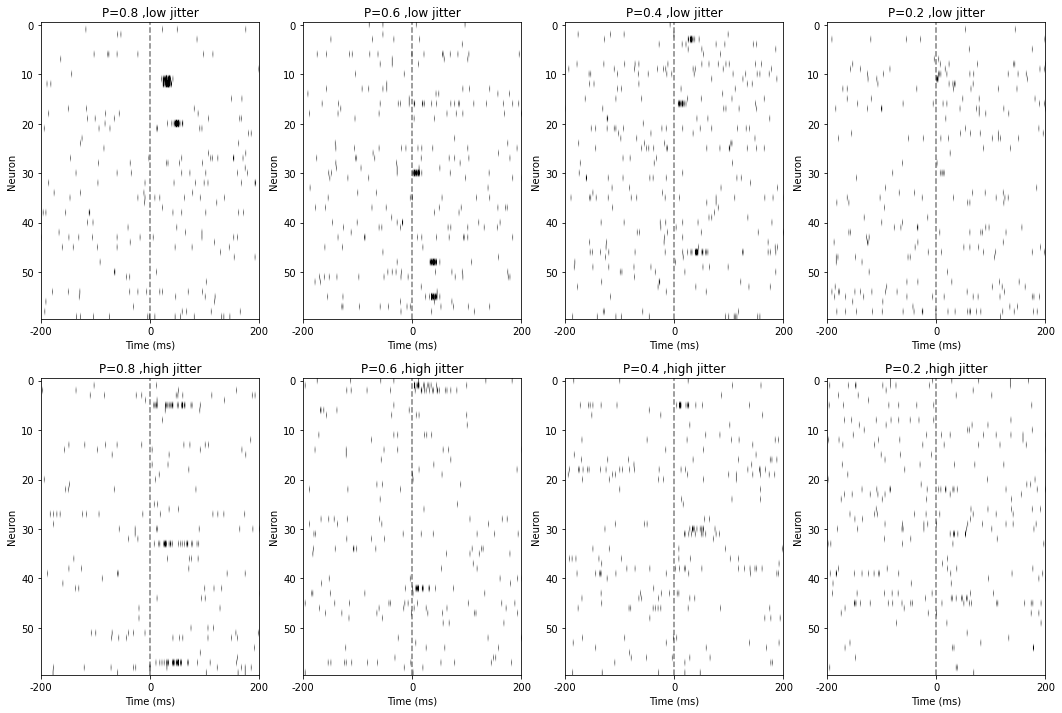

In [10]:
p_range = np.linspace(0.8, 0.2, 4)
jitter_range = [0.005, 0.02]
duration=2
neurons = 60
trials = 30
nr_in_sequence = 3
seq_window=50
seq_time = int(duration/2*1000)

plt.figure(figsize=(18, 12))
for ij, j in enumerate(jitter_range):
    for ip, p in enumerate(p_range):
        plt.subplot(len(jitter_range), len(p_range), ip+len(p_range)*ij+1)
        spk_matrix, spk_matrix_cut, sorted_seq = sim_event_locked_sequence(neurons, trials, duration, j, nr_in_sequence, seq_window, seq_time, p)
        print("Simulated sequence:", sorted_seq)
        plt.title("P="+str(round(p,1))+" ,"+["low","high"][ij]+" jitter")
        plt.imshow(np.sum(spk_matrix,axis=0),aspect='auto',cmap='gray_r', vmin=0, vmax=1)
        plt.xticks(range(0, spk_matrix.shape[2], 200), range(-seq_time,seq_time, 200))
        plt.xlabel('Time (ms)')
        plt.ylabel('Neuron')
        ylims = plt.ylim()
        plt.vlines(x = seq_time, ymin=ylims[0], ymax= ylims[1],linestyle='--', color='black', alpha=0.5)
        plt.xlim([seq_time-200, seq_time+200])
#plt.savefig('Figure1.svg')
#plt.savefig('Figure1.jpg')
plt.show()        

# Finding the ranks and occ of the data

In [12]:
def firing_ranks_spkmatrix(spikes_slice):
    """
    Function made by Pepijn van den Berg.
    Compute the ranks (i.e., the order in which the neurons spiked) of the given data
    """
    
    # Make a vector for average spike times per neuron
    avg_spike = np.zeros([spikes_slice.shape[1]])
    
    # Make a matrix of ranks for each trial
    ranks = np.full([spikes_slice.shape[0], spikes_slice.shape[1]], np.nan)

    for trial in range(spikes_slice.shape[0]):    
        # Find average spiking time per neuron
        for ineuron in range(spikes_slice.shape[1]):
            avg_spike[ineuron] = np.mean([bin_idx for bin_idx, activity in enumerate(spikes_slice[trial, ineuron]) if activity > 0])
        
        # Sort the neurons, based on their avg spiking time
        sorted_neurons = np.argsort(avg_spike)

        # Fill the rank matrix, but only for the defined 'rank-slots'
        for ineuron, neuron in enumerate(sorted_neurons):
            if not np.isnan(avg_spike[neuron]):
                ranks[trial,ineuron] = neuron 
    return ranks

In [13]:
def firing_ranks2occ_matrix(firing_ranks):
    """
    Function made by Tom Has.
    Constructs an occurrence matrix from firing ranks where occ[x, y] represents how often neuron x had rank y.
    Input:  - firing_ranks: Array containing for each rank in each trial which neuron had this rank in this trial
    Output: - occ:          Occurrence matrix
    """
    n_neurons = firing_ranks.shape[1]
    occ = np.zeros((n_neurons, n_neurons), dtype=int)
    # Loop over trials
    for trial in firing_ranks:
        # Loop over ranks:
        for rank, neuron in enumerate(trial):
            if np.isnan(neuron):
                continue
            # For not nan rank, neuron pairs, increment the respective square in the occurrence matrix|
            occ[int(neuron), rank] += 1
    return occ

In [14]:
def sort_occ_matrix(occ_matrix, mean_rank=False):   
    """"
    Function made by Pepijn van den Berg
    Modifies an occ matrix to only active neurons and 'used' rank positions. 
    Also, it sorts the matrix, either based on mean rank, or on mode rank.
    """
    # Find active neurons
    active_neurons = np.where(np.any(occ_matrix!=0, axis=1))[0]

    # Find non-zero rank range
    active_ranks = np.where(np.any(occ_matrix!=0, axis=0))[0]
    if len(active_ranks)==0:
        rank_limit = 1
    else:
        rank_limit = active_ranks[-1]

    # Pick 'active' rows of occ_matrix, for relevant rank range
    occ_matrix = occ_matrix[active_neurons, 0:rank_limit+1]
    
    # Compute max rank
    max_ranks = np.argmax(occ_matrix, axis=1)
    
    # Compute mean rank
    mean_ranks = np.zeros(len(active_neurons))
    for ineuron, neuron in enumerate(active_neurons):
        mean_ranks[ineuron] = np.mean(occ_matrix[ineuron,:]*np.arange(rank_limit+1))
    
    
    # Return sorted occ matrix
    if mean_rank:
        return [occ_matrix[np.argsort(mean_ranks),:], np.argsort(mean_ranks), active_neurons]
    else:
        return [occ_matrix[np.argsort(max_ranks),:], np.argsort(max_ranks), active_neurons]

In [12]:
neurons = 60
trials = 30
duration = 2 # In seconds
jitter = 0.01 # Amount of noise for the exact spiking times of the neurons in the sequence
seq_window = 50 # In ms
seq_time = 1000 # At what time the sequence is elicited (in ms)
p_sequence = 0.4
nr_in_sequence = 6

In [13]:
spk_matrix, spk_matrix_cut, sorted_seq = sim_event_locked_sequence(neurons, trials, duration, jitter, nr_in_sequence, seq_window*5, seq_time, p_sequence)

print("Sequence:", sorted_seq)

# Find the rank and occ matrix 
ranks = firing_ranks_spkmatrix(spk_matrix_cut)   
occ_matrix = firing_ranks2occ_matrix(ranks)

sorted_occ_1, order_1, active_neurons_1 = sort_occ_matrix(occ_matrix)

spk_matrix, spk_matrix_cut, sorted_seq = sim_event_locked_sequence(neurons, trials, duration, jitter, nr_in_sequence, seq_window*5, seq_time, p_sequence, seq=False)

print("Sequence:", sorted_seq)

# Find the rank and occ matrix 
ranks = firing_ranks_spkmatrix(spk_matrix_cut)   
occ_matrix = firing_ranks2occ_matrix(ranks)

sorted_occ_2, order_2, active_neurons_2 = sort_occ_matrix(occ_matrix)


sorted_occs = [sorted_occ_1,sorted_occ_2]
orders = [order_1, order_2]
active_neurons_lists = [active_neurons_1, active_neurons_2]

Sequence: [46 51  5 26 25 39]
Sequence: [53 48  0  1 40 28]


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


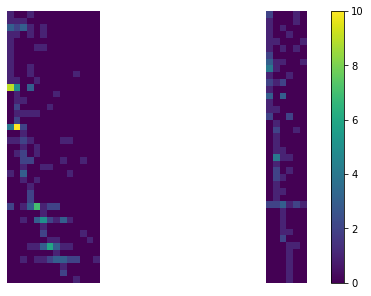

In [14]:
from matplotlib.colors import Normalize
import matplotlib.cm as cm

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8.5, 5))
cmap = cm.get_cmap('viridis')
normalizer = Normalize(0, np.max(sorted_occ_1))
im = cm.ScalarMappable(norm=normalizer)

axes.flat[0].set_axis_off()
axes.flat[0].imshow(sorted_occs[0],cmap=cmap, norm=normalizer)

axes.flat[1].set_axis_off()
axes.flat[1].imshow(sorted_occs[1], cmap=cmap, norm=normalizer)
fig.colorbar(im, ax=axes.ravel().tolist())
#plt.savefig('Figure2.svg')
#plt.savefig('Figure2.jpg')
plt.show()

# Computing MI and significance 

In [15]:
def MI(M):
    """
    Function made by Tom Has.
    Calculates the mutual information between the 2 axes of a matrix.
    Input:  - M:  2d matrix
    Output: - MI: Mutual information
    """
    sizex = M.shape[0]
    sizey = M.shape[1]
    total = np.sum(M)
    p_Y = np.sum(M, axis=0) / total
    p_X = np.sum(M, axis=1) / total
    # MI = sum over x and y: p(x,y) * log(p(x,y) / (p(x) * p(y)))
    #    = sum over x and y: M(x,y)/total * log((M(x,y) * total) / (p_X(x) * p_Y(y)))
    MI = sum([sum([(
        0 if M[x, y] == 0 else
        M[x, y] / total * np.log((M[x, y] / total) / (p_X[x] * p_Y[y]))
    ) for x in range(sizex)]) for y in range(sizey)])
    return MI

In [13]:
def getURI(firing_times_per_trial, nr_surrogates):
    # global avg_firing_time
    """
    Function made by Tom Has.
    Computes the mutual information between unit and firing rank.
    Firing rank is defined as the place in the order of average firing times for a neuron within a trial.
    Input:  - firing_times_per_trial: 2d array containing for each neuron, for each trial the list of firing times
                                      that this neuron produced in this trial.
            - nr_surrogates:          Number of shuffled occurrence matrices to compute p-value. Gets more accurate
                                      with higher numbers.
    Output: - URI:                    The calculated URI metric.
            - occurrence_matrix:      The occurrence matrix between neuron and rank
            - p-value:                p-value from surrogate calculation. Can be interpreted as the probability of
                                      URI metric being as high as it is under null-hypothesis (no sequence).
    """
    ranks = firing_ranks_spkmatrix(firing_times_per_trial)    
    occurrence_matrix = firing_ranks2occ_matrix(ranks)
    URI = MI(occurrence_matrix)
    surrogates = get_surrogate_MIs(ranks, nr_surrogates)
    URI_p_val = np.count_nonzero(surrogates >= URI) / nr_surrogates
    return URI, URI_p_val, occurrence_matrix

In [14]:
def get_surrogate_MIs(firing_ranks, n_surrogates):
    """
    Function made by Tom Has.
    Computes a number of MI scores belonging to unit-rank shuffled versions of firing_ranks
    Input:  - firing_ranks: Array containing for each rank in each trial which neuron had this rank in this trial
            - n_surrogates: Number of shuffles / number of surrogate scores obtained
    Output: - MIs:          MI scores belonging to the surrogates (1 score per surrogate)
    """
    # Create a copy of firing_ranks
    ranks = firing_ranks.copy()
    # Create an array for return values
    MIs = np.empty(n_surrogates)
    # Loop n_surrogates times
    for nr in range(n_surrogates):
        for trial in ranks:
            # Get the valid indices (not nan)
            ivalid = np.where(~np.isnan(trial))[0]
            # Shuffle trials and ranks
            trial[ivalid] = trial[rng.permutation(ivalid)]

        occ = firing_ranks2occ_matrix(ranks)
        MIs[nr] = MI(occ)
    return MIs

In [15]:
def event_locked_seq(spk_matrix, seq_time, win, n_surrogates):
    """
    Function made by Pepijn van den Berg
    Returns the URI, p-value and occ-matrix when timelocked to the stimulus
    """    
    URI, URI_p_val, occurrence_matrix = getURI(spk_matrix[:,:,seq_time:seq_time+win], n_surrogates)
    return URI, URI_p_val, occurrence_matrix

------------------------------------------------------------------------------------------------

# Accuracy of non-sequential data

In [19]:
neurons = 60
trials = 30
duration = 2
seq_time= int(duration/2*1000)
n_surrogates = 200
n_simulations = 500

In [20]:
win_range = [5, 25, 50, 75, 100, 125, 150, 175, 200]
p_list = np.zeros([n_simulations, len(win_range)])

for n in range(n_simulations):
    spk_matrix, spk_matrix_cut, sorted_seq = sim_event_locked_sequence(neurons, trials, duration, 0, 1, 1, 1, 1, seq=False)

    for iw, w in enumerate(win_range):
        URI_p_val = event_locked_seq(spk_matrix, seq_time, w, n_surrogates)[1]
        p_list[n, iw] = URI_p_val

0
1
2
3
4
5
6


C:\Users\pepij\AppData\Local\Temp\ipykernel_5932\891461473.py:10: RuntimeWarning: invalid value encountered in divide
  p_Y = np.sum(M, axis=0) / total
C:\Users\pepij\AppData\Local\Temp\ipykernel_5932\891461473.py:11: RuntimeWarning: invalid value encountered in divide
  p_X = np.sum(M, axis=1) / total


7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280


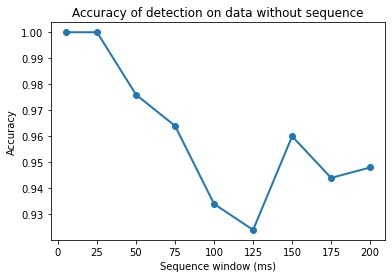

In [22]:
accuracy = [np.count_nonzero(p_list[:,i]>0.05)/n_simulations for i in range(len(win_range))]
plt.figure()
plt.title('Accuracy of detection on data without sequence')
plt.plot(win_range, accuracy, lw=2)
plt.scatter(win_range, accuracy)
plt.xlabel('Sequence window (ms)')
plt.ylabel('Accuracy')
plt.savefig('Figure3.svg')
plt.savefig('Figure3.jpg')
plt.show()

# Nr of trials necessary for finding sequence (p < 0.05)

In [19]:
neurons = 60
duration = 2
seq_time= int(duration/2*1000)
win = 50
trials = 80
n_surrogates = 200
n_simulations = 30

p_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
jitter_range = [0.005, 0.01, 0.02]

In [186]:
n_matrix = np.zeros([len(p_range), len(jitter_range), n_simulations])

for ip, p in enumerate(p_range):
    for ijitter, jitter in enumerate(jitter_range):
        for n in range(n_simulations):
            nr_in_sequence = np.random.randint(2, 11)
            spk_matrix, spk_matrix_cut, sorted_seq = sim_event_locked_sequence(neurons, trials, duration, jitter, nr_in_sequence, seq_window, seq_time, p)
            for n_trials in range(1,trials):
                if event_locked_seq(spk_matrix[:n_trials], seq_time, win, n_surrogates)[1] > 0.05:
                    n_matrix[ip, ijitter, n] = n_trials
            if n_matrix[ip, ijitter, n] == 0:
                n_matrix[ip, ijitter, n] = trials               

0.1
0.005
0
1


C:\Users\pepij\AppData\Local\Temp\ipykernel_22564\705524249.py:10: RuntimeWarning: invalid value encountered in divide
  p_Y = np.sum(M, axis=0) / total
C:\Users\pepij\AppData\Local\Temp\ipykernel_22564\705524249.py:11: RuntimeWarning: invalid value encountered in divide
  p_X = np.sum(M, axis=1) / total


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0.1
0.01
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0.1
0.02
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0.2
0.005
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0.2
0.01
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0.2
0.02
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0.3
0.005
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0.3
0.01
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0.3
0.02
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0.4
0.005
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0.4
0.01
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0.4
0.02
0
1
2
3
4
5
6
7
8
9
10

In [16]:
n_matrix_copy = np.array([[[29., 17., 78., 36., 76., 40., 21., 78., 62., 27., 22., 31.,
         34., 52., 12.,  5., 71., 54., 78.,  4.,  8., 39., 26., 35.,
         79., 42., 58., 26., 29., 24.],
        [79., 79., 75., 79., 54., 64., 24., 65., 79., 74., 79., 79.,
         79., 26., 79., 55., 22., 12., 79., 79., 79., 70., 79., 24.,
         79., 67., 79., 68., 59., 79.],
        [79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 68., 64.,
         28., 79., 79., 79., 79., 37., 79., 79., 79., 79., 79., 79.,
         79., 79., 79., 79., 79., 79.]],

       [[39.,  5.,  4., 12.,  9.,  6., 12., 14.,  7., 11., 10.,  2.,
         26., 28., 35., 28., 33., 25., 17., 12., 16., 30., 22., 23.,
         16., 18., 45., 35., 30., 14.],
        [63., 52., 45., 69., 20., 22.,  4., 31., 35., 79., 30., 14.,
         37., 35., 69., 35., 79., 43.,  8., 28., 79., 38., 34., 27.,
         13., 47., 53., 43., 48., 26.],
        [79., 44., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79.,
         79., 61., 79., 33., 79., 79., 38., 79., 63., 76., 79., 79.,
         79., 47., 79., 79., 79., 79.]],

       [[11., 14.,  9., 19., 24., 15., 32.,  8., 15.,  4., 13., 14.,
          6., 11.,  9., 15., 25.,  7., 29., 24., 29., 18., 31., 14.,
          8., 13.,  6., 10.,  7., 11.],
        [31., 32.,  8., 26., 38., 13., 14., 13., 26., 22., 26., 25.,
         29., 32., 36.,  4., 36., 25., 30., 11., 31., 22., 12., 18.,
         25., 17.,  5., 25.,  6.,  9.],
        [79., 56., 79., 57., 79., 79., 34., 79., 32., 79., 79., 79.,
         34., 79., 78., 67., 76., 79., 79., 79., 57., 79., 79., 79.,
         74., 62., 79., 79., 79., 79.]],

       [[ 8.,  4., 10.,  4.,  8., 14.,  9.,  3.,  8.,  6.,  5.,  6.,
         20.,  4.,  7., 23.,  5.,  8.,  5.,  2.,  1.,  4., 15.,  8.,
          3.,  7., 13.,  7.,  4., 28.],
        [ 7., 20., 46.,  9., 10., 28., 34.,  8., 23., 15.,  8., 20.,
         43.,  8.,  6., 18., 78., 12., 12., 14., 16., 35., 23., 23.,
         17.,  1., 26., 26., 19.,  4.],
        [66., 60., 25., 79., 64., 79., 46., 79., 65., 58., 28., 79.,
         33., 79., 79., 79., 79., 79., 54., 41.,  7., 58., 79., 79.,
         79., 79., 79., 79., 79., 79.]],

       [[ 8., 11.,  4.,  3.,  5., 13.,  1.,  4.,  1., 13.,  4.,  6.,
          9.,  2.,  1.,  7.,  6.,  9., 14.,  4.,  8.,  2.,  2.,  2.,
          6.,  5.,  5.,  5.,  3.,  6.],
        [ 7., 17.,  6.,  4.,  9., 12., 10., 10.,  9., 21.,  3.,  5.,
          5., 16., 19., 32., 10., 16.,  5., 10., 11., 20.,  7.,  7.,
         27.,  6., 10., 13., 15., 43.],
        [33., 79., 66., 33., 47., 79., 79., 79., 79., 69., 79., 79.,
         34., 19., 59.,  7., 47., 79., 79., 47., 79., 48., 73., 79.,
         79., 78., 71., 17., 58., 79.]],

       [[ 5.,  6.,  3.,  3.,  9.,  4.,  8.,  3.,  3.,  4.,  4.,  7.,
          4.,  5.,  6.,  8., 13.,  3.,  1.,  5.,  8.,  2.,  4.,  5.,
         12.,  6.,  4.,  7.,  6.,  3.],
        [ 4., 10., 48.,  3.,  9., 16.,  4.,  6.,  5., 17.,  2.,  5.,
         12., 15., 13.,  5., 22., 23.,  6., 11., 15.,  4.,  4.,  3.,
          8.,  4., 11.,  9.,  7.,  5.],
        [30., 66., 15., 55., 62., 72., 16., 79., 76., 68., 79., 54.,
         49., 79., 34., 63., 42., 79., 26.,  9., 39., 37., 12., 79.,
         79., 57., 43., 50., 37., 37.]],

       [[10.,  3.,  2.,  5.,  3.,  5.,  5.,  2., 12.,  3.,  3., 12.,
          8.,  3.,  3.,  5.,  3.,  6., 13.,  5.,  2.,  4.,  3.,  3.,
          4.,  7.,  7.,  2.,  2.,  2.],
        [ 5., 10., 18.,  7.,  3.,  5., 46., 11.,  5.,  9.,  7.,  5.,
          7.,  1., 24.,  1.,  9.,  1.,  5.,  6., 13., 11., 12.,  6.,
          5., 13.,  2., 10., 61., 25.],
        [22., 79.,  5., 50., 79., 16., 77., 20., 14., 21., 79., 79.,
         59., 32., 57., 30., 69., 53., 27., 79., 79., 79., 67., 34.,
         27., 63., 54., 78., 35., 47.]],

       [[ 1.,  4.,  5.,  4.,  4., 10.,  9.,  3.,  1.,  7.,  6.,  1.,
          5.,  3.,  1.,  2.,  5.,  3.,  5.,  1.,  3.,  8.,  2.,  3.,
          1.,  5.,  5.,  2.,  7.,  2.],
        [10.,  6.,  3.,  8., 21., 11.,  7.,  7.,  3.,  6.,  8.,  8.,
          4.,  2., 13., 10.,  1., 16., 13., 10.,  1., 14.,  2.,  2.,
          5., 12.,  2.,  3., 14.,  1.],
        [ 8., 40., 29., 73., 35., 69., 25., 19., 76., 26., 49., 22.,
         78., 26., 24., 25., 25., 48., 25., 76., 58., 18., 30., 16.,
         42., 47., 38., 21., 67., 20.]],

       [[ 4.,  6.,  3.,  3.,  3.,  1.,  3.,  2.,  4.,  3.,  3.,  5.,
          4.,  2.,  5.,  3.,  4.,  2.,  4.,  3.,  4., 10.,  1., 17.,
          6.,  1.,  5.,  3.,  4.,  2.],
        [ 2., 10.,  9.,  5.,  2.,  7.,  5.,  3.,  8., 13., 10., 11.,
          6.,  5.,  7.,  6.,  6.,  7.,  5.,  3.,  6.,  9.,  7., 14.,
          5., 13.,  5.,  7.,  1.,  8.],
        [44., 16., 26., 77., 22., 54., 18., 20., 12., 43., 68., 79.,
         13., 71., 47., 79., 18., 29., 58., 44., 23., 16., 39., 18.,
         79., 79., 25., 33., 76., 28.]]])


idx = np.where(n_matrix_copy == 79)
n_matrix_copy[idx] = np.nan

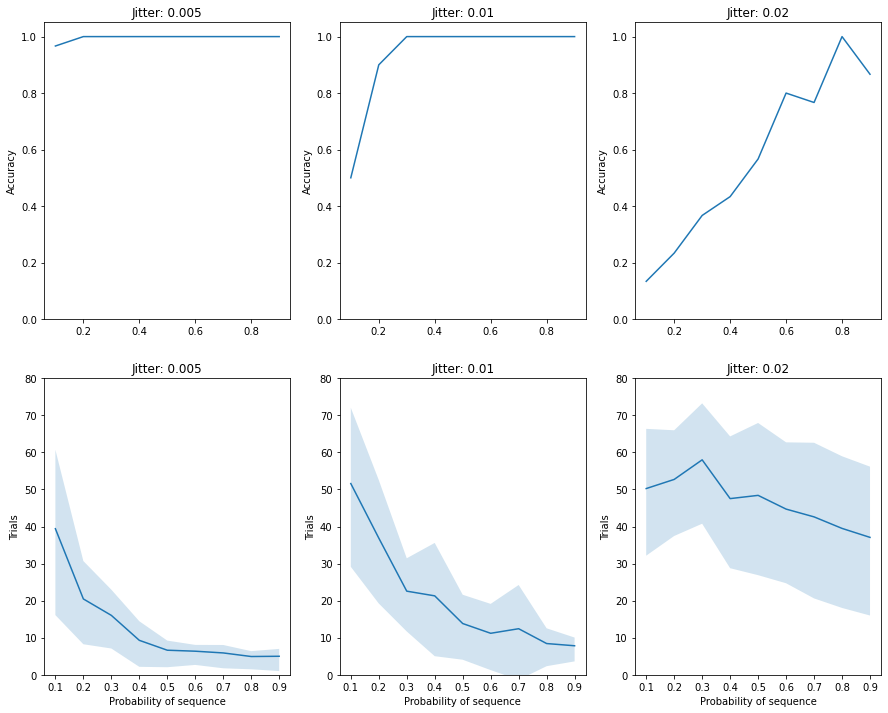

In [279]:
jitter_labels = ['0.005', '0.01', '0.02']

plt.figure(figsize=(15,12))
for i in range(3):
        plt.subplot(2, 3, i+1)
        plt.title('Jitter: '+jitter_labels[i])
        plt.plot(p_range, np.count_nonzero(n_matrix_copy[:,i] > 0, axis=1)/30)
        plt.ylim([0,1.05])
        plt.margins(y=1)
        plt.ylabel('Accuracy')
    
for i in range(3):        
    plt.subplot(2, 3, i+4)
    plt.title('Jitter: '+jitter_labels[i])
    plt.plot(p_range, np.nanmean(n_matrix_copy[:,i], axis=1)+1)
    plt.ylim(0, 80)
    plt.xticks(np.arange(0.1, 1, 0.1))
    plt.xlabel('Probability of sequence')
    plt.ylabel('Trials')
    plt.fill_between(p_range, np.nanmean(n_matrix_copy[:,i], axis=1)+np.nanstd(n_matrix_copy[:,i], axis=1), np.nanmean(n_matrix_copy[:,i], axis=1)-np.nanstd(n_matrix_copy[:,i], axis=1), alpha=0.2)

    
plt.savefig('Figure4.svg')
plt.savefig('Figure4.jpg')
plt.show()

# Undershooting and overshooting sequence window length

In [23]:
seq_t_window = np.linspace(-40, 150, 25)
seq_time = 1000
seq_window = 50
n_simulations = 10
p_window = [0.8, 0.5, 0.2]
jitter_range = [0.005, 0.01, 0.02]
p_ = np.zeros([n_simulations, len(seq_t_window), 3])
URI_ = np.zeros([n_simulations, len(seq_t_window), 3])
trials = 30

for noise in range(3):
    p_sequence = p_window[noise]
    jitter = jitter_range[noise]
    for n in range(n_simulations):
        nr_in_sequence = np.random.randint(2, 11)
        spk_matrix, spk_matrix_cut, sorted_seq = sim_event_locked_sequence(neurons, trials, duration, jitter, nr_in_sequence, seq_window, seq_time, p_sequence)
        
        for it, t in enumerate(seq_t_window):
            URI, URI_p_val, occurrence_matrix = event_locked_seq(spk_matrix, seq_time, seq_window+int(t), 100)
            p_[n, it, noise] = URI_p_val     
            URI_[n, it, noise] = URI

0
1
2


In [1]:
fig = plt.figure(figsize=(15,7))
plt.subplot(1, 2, 1)
plt.plot(seq_t_window, np.mean(p_[:,:,0], axis=0), label = 'Low noise', lw=2)
plt.plot(seq_t_window, np.mean(p_[:,:,1], axis=0), label = 'Moderate noise', lw=2)
plt.plot(seq_t_window, np.mean(p_[:,:,2], axis=0), label = 'High noise', lw=2)
plt.xticks([-40, 0, 40, 80, 120, 160])
plt.hlines(y=0.05, xmin=-40, xmax=seq_t_window[-1], ls='--', color='k', alpha=0.3, label='p = 0.05')
plt.legend()
plt.margins(x=0)
plt.ylim(0,1)
plt.xlabel('Sequence duration - time window (ms)')
plt.ylabel('P-value')


plt.subplot(1, 2, 2)
plt.plot(seq_t_window, np.mean(URI_[:,:,0], axis=0),label = 'Low noise', lw=3)
plt.plot(seq_t_window, np.mean(URI_[:,:,1], axis=0),label = 'Moderate noise', lw=3)
plt.plot(seq_t_window, np.mean(URI_[:,:,2], axis=0),label = 'High noise', lw=3)
plt.ylabel('MI')
plt.xlabel('Sequence duration - time window (ms)')
plt.xticks([-40, 0, 40, 80, 120, 160])
ylims=plt.ylim()
plt.vlines(x=0, ymin=ylims[0], ymax=ylims[1], linestyle='--', color='k', alpha=0.3)
plt.margins(x=0)
plt.margins(y=0)

plt.show()

NameError: name 'plt' is not defined

# Sequence recovery: testing the algorithm

In [32]:
def MI_decrease(ranks, neurons):
    """
    Function made by Pepijn van den Berg.
    Calculates all the MIs after pruning each neuron individually.
    Input: 
    - ranks           : the ranks of all the trials
    - neurons         : a list of all neurons

    Output:
    - MIs_sorted      : all MIs after pruning, sorted
    - neurons_sorted  : all neurons, sorted on their MI after pruning
    """
    # Calculate MI before pruning
    baseline_MI = MI(firing_ranks2occ_matrix(ranks))
    
    MIs = np.zeros(len(neurons))
    
    # Prune each neuron individually from the original ranks and calculate MI
    for ineuron, neuron in enumerate(neurons):
        ranks_candidate, MI_candidate = cut_ranks(ranks, neuron)
        MIs[ineuron] = MI_candidate

    # Sort the MIs based on their decrease
    MIs_sorted = baseline_MI - np.sort(MIs)

    # Sort the neurons according to their decrease  (larger decreases resemble a higher likelihood to be part of the sequence)
    neurons_sorted = np.array(neurons)[np.argsort(MIs)]
    return MIs_sorted, neurons_sorted

def construct_sequence(ranks, n_neurons, n_surrogates, threshold=0.05, mode="max", max_neurons=10): 
    """
    Function made by Pepijn van den Berg.
    Constructs the sequence, by filtering out insignificant neurons and subsequently ordering on either the mean or mode rank.
    Input:
    - ranks          :  the ranks of all the trials.
    - n_neurons      :  the total number of neurons in the data.
    - n_surrogates   :  the number of surrogates used for testing significance of individual neurons
    - prudence :        value between 0 and 1. the higher, the more the algorithm prefers low sequence lengths. 
                        high prudence is especially recommended when prioritizing precision over recall.
    - mode           :  either "mean" or "max". decides how the significant neurons are ordered to find sequence order.
    - max_neurons    :  the maximum sequence length. 

    Output:
    - sequence             :  a list containing the ordered sequence
    """

    # Find MIs with the largest decrease after pruning the neurons individually
    MIs, seq_neurons = MI_decrease(ranks, range(n_neurons))
    MIs = MIs[:max_neurons]
    seq_neurons = seq_neurons[:max_neurons]
    
    MIs_surrogate = np.zeros([n_surrogates, max_neurons])

    # Keep track of total number of surrogates that have a larger MI decrease after pruning the x'th most significant neuron
    for s in range(n_surrogates):
        for ineuron in range(max_neurons):
            print(seq_neurons[ineuron])
            surrogate = surrogate_ranks(ranks, seq_neurons[ineuron])
            occ = firing_ranks2occ_matrix(surrogate)
            MIs_surrogate[s, ineuron] = MI(firing_ranks2occ_matrix(surrogate)) - cut_ranks(surrogate, seq_neurons[ineuron])[1]

    insignificant = np.array([np.count_nonzero(MIs_surrogate[:,ineuron]>=MIs[ineuron])/n_surrogates > threshold for ineuron in range(max_neurons)], dtype=int)
    ratios = [np.count_nonzero(MIs_surrogate[:,ineuron]>=MIs[ineuron])/n_surrogates for ineuron in range(max_neurons)]
    
    if len(np.where(insignificant==0)[0])>0:
        seq_neurons = seq_neurons[np.where(insignificant==0)[0]]
    else:
        seq_neurons = seq_neurons[:3]
    
    
    occ_matrix = firing_ranks2occ_matrix(ranks)
    
    # Compute mean and maximum ranks
    mean_ranks = np.zeros(len(seq_neurons))
    max_ranks = np.zeros(len(seq_neurons))
    for ineuron, neuron in enumerate(seq_neurons):        
        mean_ranks[ineuron] = np.mean(occ_matrix[neuron,:]*np.arange(occ_matrix.shape[1]))
        max_ranks[ineuron] = np.argmax(occ_matrix[neuron,:])

    # Sort the sequence neurons
    if mode == "mean":
        sequence = np.array(seq_neurons)[np.argsort(mean_ranks)]
    else: 
        sequence = np.array(seq_neurons)[np.argsort(max_ranks)]

    # Create the template
    template = np.zeros([occ_matrix.shape[0], occ_matrix.shape[0]])

    for rank, neuron in enumerate(sequence):
        template[neuron, rank] = 1

    # Create the null-template
    null_template = np.zeros([occ_matrix.shape[0], occ_matrix.shape[0]])
    null_template[sequence,:len(sequence)] = 1/len(sequence)

    return sequence, template, null_template, MIs, MIs_surrogate, ratios

def cut_ranks(ranks, neuron):
    """
    Function made by Pepijn van den Berg.
    Prunes the ranks by removing the specified neuron out of all trial ranks, and replacing them with np.nan.
    The cut rank-matrix is returned, as well as its mutual information.
    """
    pruned_ranks = np.zeros([ranks.shape[0], ranks.shape[1]])
    for itrial in range(ranks.shape[0]):
        trial = list(ranks[itrial])
        if neuron in trial:
            trial.remove(neuron)
            trial.append(np.nan)
        pruned_ranks[itrial] = trial    
    return pruned_ranks, MI(firing_ranks2occ_matrix(pruned_ranks))

def surrogate_ranks(firing_ranks, neuron): 
    """
    Function made by Pepijn van den Berg.
    Surrogate ranks are created by randomly shuffling the ranks of all spikes of the given neuron. 
    The sequential information of all other neurons remain untouched.
    """
    ranks = np.zeros([firing_ranks.shape[0], firing_ranks.shape[1]])
    
    for itrial, trial in enumerate(firing_ranks):
        if np.any(trial==neuron):
            trial_list = list(trial)
            spike_indices = np.sort(np.where(trial==neuron)[0],)[::-1]
            
            for spike_idx in spike_indices:
                trial_list.pop(spike_idx)      
            for spk in range(len(spike_indices)):
                ivalid = np.where(~np.isnan(trial))[0]
                n_slots = len(ivalid)+1
                new_rank = np.random.randint(n_slots)
                trial_list.insert(new_rank, neuron)
            ranks[itrial,:] = np.array(trial_list)
        else:
            ranks[itrial,:] = firing_ranks[itrial]
    return ranks
    

Sequence: [ 2 18 42 29]


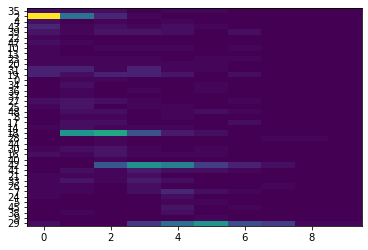

2


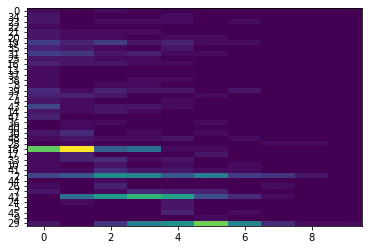

In [31]:
p_sequence=0.8
jitter=0.005
trials=100
nr_in_sequence = 4
seq_window=30
spk_matrix, spk_matrix_cut, sorted_seq = sim_event_locked_sequence(neurons, trials, duration, jitter, nr_in_sequence, seq_window*5, seq_time, p_sequence)

print("Sequence:", sorted_seq)

# Find the rank and occ matrix 
ranks = firing_ranks_spkmatrix(spk_matrix_cut)   
occ_matrix = firing_ranks2occ_matrix(ranks)

plt.figure()
plt.imshow(sort_occ_matrix(occ_matrix)[0], aspect='auto')
plt.yticks(range(sort_occ_matrix(occ_matrix)[0].shape[0]), sort_occ_matrix(occ_matrix)[2][sort_occ_matrix(occ_matrix)[1]])
plt.savefig('ExampleOcc.svg')
plt.show()
sequence, template, null_template, MIs, MIs_surrogate, ratios = construct_sequence(ranks, neurons, 100, threshold=0.05, mode="max", max_neurons=10)

In [99]:
sequence

array([29,  4, 18])

In [105]:
neurons = 60
trials = 30
duration = 2 # In seconds
jitter = 0.0 # Amount of noise for the exact spiking times of the neurons in the sequence
seq_window = 50 # In ms
seq_time = 1000 # At what time the sequence is elicited (in ms)
p_sequence = 1
nr_in_sequence = 3



Actual sequence: [ 0 11 14]


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Predicted sequence: [ 0 11 14]
Actual sequence: [29 11 16 23  3  5]


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Predicted sequence: [11 16  5 23  3]
Actual sequence: [ 5  7 20 13 21  6  8  3 17]


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Predicted sequence: [ 7 13 21  6 20  8  3 17]
Actual sequence: [18 22 15]


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Predicted sequence: [18 22]
Actual sequence: [18  2  0 27 28 22]


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Predicted sequence: [18  2]
Actual sequence: [ 5 21  0 15  4 17 23 12  9]


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Predicted sequence: [21 15  4 17 12  9]
Actual sequence: [ 9  8 18]


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Predicted sequence: [9]
Actual sequence: [ 2 17  6 26  4 19]


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Predicted sequence: [ 2 17  6 26 19]
Actual sequence: [ 3  2 11  4 26  0 15 13 16]


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Predicted sequence: [11  4 16]
Actual sequence: [ 0  8 10]


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Predicted sequence: [13 27 20]
Actual sequence: [26 19  6 27 13 17]


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Predicted sequence: [19 17 27]
Actual sequence: [11 28 13 21 10  6 29 24 14]


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Predicted sequence: [10 29 14]


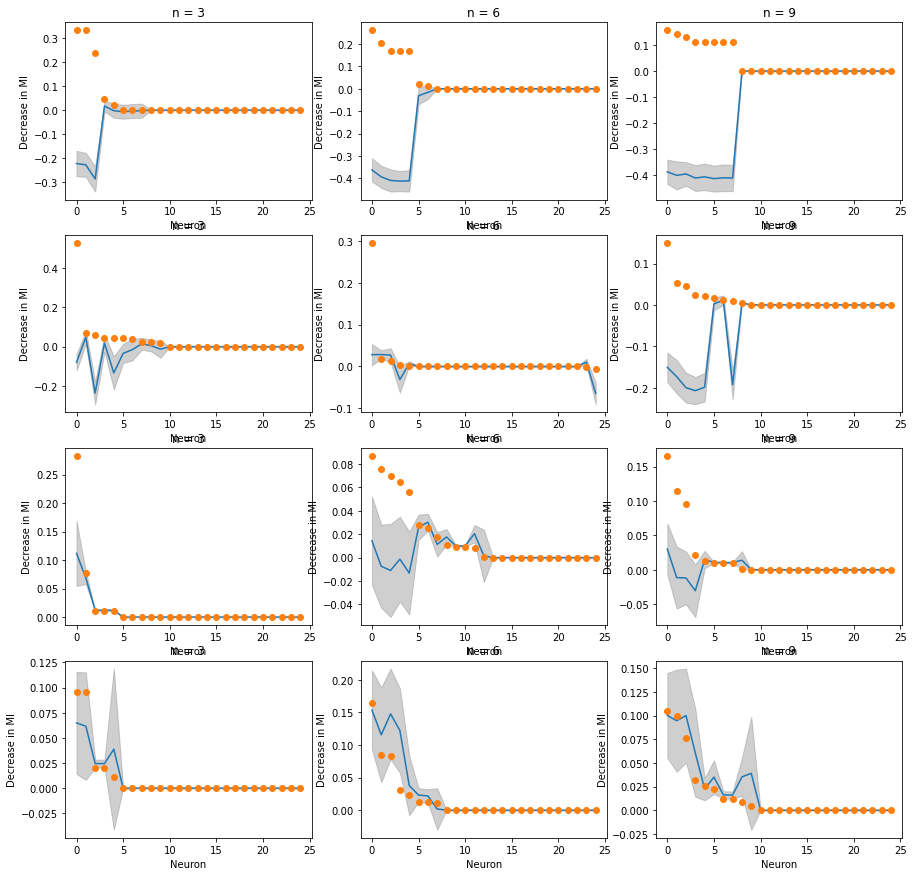

In [107]:
seq_lengths = [3, 6, 9]

p_window = [1, 0.8, 0.5, 0.3]
jitter_window = [0, 0.005, 0.01, 0.02]
threshold=0.05

plt.figure(figsize=(15,15))
for noise in range(4):
    p_sequence = p_window[noise]
    jitter = jitter_window[noise]
    for nr_in_sequence in seq_lengths:
        
        spk_matrix, spk_matrix_cut, sorted_seq = sim_event_locked_sequence(neurons, trials, duration, jitter, nr_in_sequence, seq_window, seq_time, p_sequence)
        spk_matrix_cut = spk_matrix[:,:,seq_time:seq_time+seq_window] 
        print("Actual sequence:", sorted_seq)
        
        # Find the rank and occ matrix 
        ranks = firing_ranks_spkmatrix(spk_matrix_cut)   
        occ_matrix = firing_ranks2occ_matrix(ranks)
    
        sequence, template, null_template, MIs, MIs_surrogate, ratios = construct_sequence(ranks, neurons, 150, threshold=threshold, mode="max", max_neurons=25)
    
        print("Predicted sequence:",sequence)
        
        plt.subplot(4, 3, int(noise*3+int(nr_in_sequence/3)))
        plt.plot(np.mean(MIs_surrogate, axis=0), label='Surrogates')
        plt.fill_between(range(0, MIs_surrogate.shape[1]), np.mean(MIs_surrogate, axis=0) - np.std(MIs_surrogate, axis=0), np.mean(MIs_surrogate, axis=0) + np.std(MIs_surrogate, axis=0), color='#888888', alpha=0.4)
        plt.plot(MIs, 'o')
        plt.title('n = ' + str(int(nr_in_sequence)))
        plt.xlabel('Neuron')
        plt.ylabel('Decrease in MI')
plt.savefig('Figure6.svg')
plt.savefig('Figure6.jpg')
plt.show()

In [110]:
neurons = 60
trials = 30
duration = 2 # In seconds
seq_window = 50 # In ms
seq_time = 1000 # At what time the sequence is elicited (in ms)
n_simulations = 20

0
0


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


1


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


2


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


3


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


4


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


5


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


6


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


7


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


8


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


9


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


10


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


11


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


12


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


13


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


14


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


15


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


16


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


18


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


19


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


<Figure size 432x288 with 0 Axes>

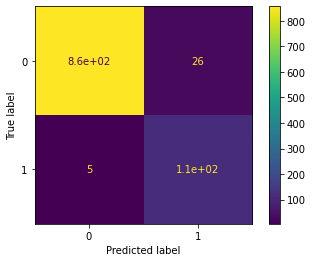

1
0


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


1


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


2


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


3


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


4


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


5


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


6


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


7


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


8


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


9


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


10


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


11


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


12


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


13


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


14


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


15


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


16


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


18


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


19


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


<Figure size 432x288 with 0 Axes>

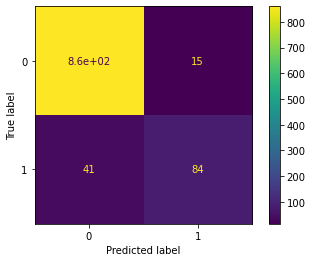

2
0


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


1


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


2


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


3


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


4


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


5


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


6


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


7


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


8


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


9


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


10


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


11


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


12


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


13


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


14


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


15


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


16


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


18


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


19


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


<Figure size 432x288 with 0 Axes>

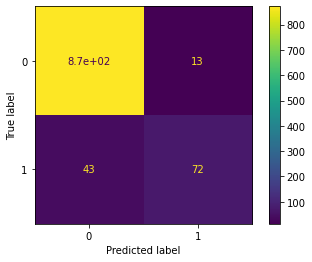

3
0


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


1


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


2


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


3


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


4


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


5


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


6


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


7


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


8


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


9


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


10


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


11


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


12


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


13


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


14


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


15


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


16


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


18


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


19


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


<Figure size 432x288 with 0 Axes>

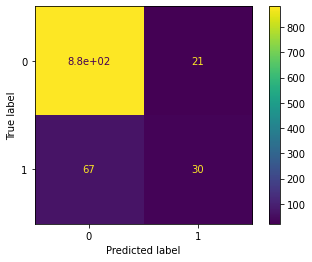

In [113]:
### precision = np.zeros(4)
recall = np.zeros(4)
precision = np.zeros(4)
p_window = [1, 0.8, 0.6, 0.4]
jitter_range = [0, 0.005, 0.01, 0.02]

fig_names_svg = ['Figure7a.svg', 'Figure7b.svg', 'Figure7c.svg', 'Figure7d.svg']
fig_names_jpg = ['Figure7a.jpg', 'Figure7b.jpg', 'Figure7c.jpg', 'Figure7d.jpg']


for noise in range(4):
    full_confusion_matrix = np.zeros([2,2])
    jitter=jitter_range[noise]
    p_sequence = p_window[noise]
    for i in range(n_simulations):
        nr_in_sequence = np.random.randint(2,11)
        spk_matrix, spk_matrix_cut, sorted_seq = sim_event_locked_sequence(neurons, trials, duration, jitter, nr_in_sequence, seq_window, seq_time, p_sequence)
        spk_matrix_cut = spk_matrix[:,:,seq_time:seq_time+seq_window*2] 
        # Find the rank and occ matrix 
        ranks = firing_ranks_spkmatrix(spk_matrix_cut)   
        occ_matrix = firing_ranks2occ_matrix(ranks)
    
        sequence, template, null_template, MIs, MIs_surrogate, ratios = construct_sequence(ranks, neurons, 150, threshold=threshold, mode="max", max_neurons=25)
    
        actual = np.zeros(neurons)
        actual[sorted_seq] = 1
    
        predicted = np.zeros(neurons)
        predicted[sequence] = 1
    
        confusion_matrix = metrics.confusion_matrix(actual, predicted, normalize = None)
        full_confusion_matrix += confusion_matrix

    precision[noise] = full_confusion_matrix[1,1] / (full_confusion_matrix[0,1]+ full_confusion_matrix[1,1])
    recall[noise] = full_confusion_matrix[1,1] / (full_confusion_matrix[1,0]+ full_confusion_matrix[1,1])

    plt.figure()
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = full_confusion_matrix, display_labels = [0, 1])
    cm_display.plot()
    plt.savefig(fig_names_svg[noise])
    plt.savefig(fig_names_jpg[noise])
    plt.show()

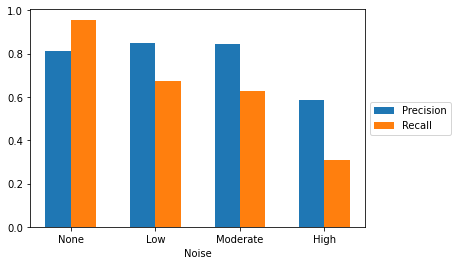

In [115]:
width=0.3
ind = np.arange(4)

plt.figure()
plt.bar(ind, precision , width, label='Precision')
plt.bar(ind + width, recall, width, label='Recall')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlabel("Noise")
plt.xticks(ind + width / 2, ('None', 'Low', 'Moderate', 'High'))
plt.savefig('Figure7e.svg')
plt.savefig('Figure7e.jpg')
plt.show()